# Analyze SFS for Python-genreated simulation data

#### Chris Porras

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
%matplotlib inline

### Identify data files by label string appended to filename

In [2]:
label = '082219'
filenames = glob.glob(('../../data/output/*%s*')%(label))

### Populate data frame with file paths and parameters

In [3]:
df = pd.DataFrame(columns=['filename','pop_size','mu','s','m'],
                  data={'filename':filenames})

In [4]:
def filename_parser(filename,params):
    return [float(filename.split(("_%s_")%(i))[1].split("_")[0]) for i in params]

In [5]:
for i in range(df.shape[0]):
    df.iloc[i,1:] = filename_parser(df.iloc[i,0],df.columns[1:]) 

In [6]:
### Make new columns for important summary stats
df['N*mu']= df['pop_size']*df['mu']
df['N*s']= df['pop_size']*df['s']
df['mu/s']= df['mu']/df['s']
df['dc']= (df['m']/df['s'])**(1/2)

In [7]:
df.sort_values(by=['N*mu','N*s','mu/s','dc']).head()

,filename,pop_size,mu,s,m,N*mu,N*s,mu/s,dc
42,../../data/output/SS_WF_freqs_pop_size_100.0_m...,100,0,0.001,0.0001,0,0.1,0,0.316228
216,../../data/output/SS_WF_freqs_pop_size_100.0_m...,100,0,0.001,0.001,0,0.1,0,1
10,../../data/output/SS_WF_freqs_pop_size_100.0_m...,100,0,0.001,0.01,0,0.1,0,3.16228
132,../../data/output/SS_WF_freqs_pop_size_100.0_m...,100,0,0.001,0.1,0,0.1,0,10
349,../../data/output/SS_WF_freqs_pop_size_100.0_m...,100,0,0.01,0.0001,0,1,0,0.1


### Gaussian sampling from frequency lattice

In [8]:
from scipy.ndimage import gaussian_filter

In [9]:
def sample_f(f,sigma):
    F = np.zeros(f.shape)
    ## Need to convolve array along spatial axes
    ## so iterate over time axis
    for i in range(f.shape[0]):
        F[i] = gaussian_filter(f[i],sigma=sigma,mode = "wrap")
    return F

### $\langle \zeta \rangle$ calculator

In [10]:
from scipy.special import binom
def freq_sfs(f,n):
    if np.isscalar(f):
        sfs = np.zeros(n+1)
    else:
        sfs = np.zeros(tuple([n+1]) + f.shape)
    for j in range(n+1):
        sfs[j] = binom(n,j)*f**j * (1-f)**(n-j)
    return sfs

In [33]:
def plot_sfs(df,sig_list,n):
    for i in range(df.shape[0]):
        f = np.load(df['filename'][i])
        m = df['m'][i]
        s = df['s'][i]
        mu = df['mu'][i]
        pop_size = df['pop_size'][i]
        dims = f.shape[1:]

        #make plot over j for all sfs(s,sigma)
        plt.figure(figsize=(10.0,8.0))
        title = (('n=%s_s=%s_')%(n,s) \
                + r'$N\mu$='+('%s_')%(pop_size*mu) \
                + r'$Ns$='+('%s_')%(pop_size*s) \
                + r'$d_c=$'+('%s_')%(np.round(np.sqrt(m/s),decimals=2)) \
                + ('dims=%s')%(str(dims)))
        plt.title(title)
        plt.xlabel(r'$j$')
        plt.ylabel(r'$\zeta_{s,\sigma}$')

        # j is sample size out of n
        j = np.arange(n+1) 

        for sig in sig_list:
            sigma = sig
            #sample from f with range of sigma
            F = sample_f(f,sigma)
            #average sampled f over intervals,reps,dims
            sfs = freq_sfs(F,n)
            sfs_avg = np.mean(sfs,axis=(1,2,3))
            label = ((r'$\sigma$ = %s')%(sigma))
            plt.loglog(j,sfs_avg,label=label)

        plt.legend()
        plt.savefig(f'../../data/figures/SFS_{title}.png')
        plt.show()

In [36]:
test_sims= pd.DataFrame.reset_index(df[(df['dc']==10) & \
                (df['N*mu']<1) & (df['pop_size'] > 100)],drop=True)
test_sims

,filename,pop_size,mu,s,m,N*mu,N*s,mu/s,dc
0,../../data/output/SS_WF_freqs_pop_size_1000000...,1e+06,0,0.001,0.1,0,1000,0,10
1,../../data/output/SS_WF_freqs_pop_size_100000....,100000,0,0.001,0.1,0,100,0,10
2,../../data/output/SS_WF_freqs_pop_size_10000.0...,10000,0,0.001,0.1,0,10,0,10
3,../../data/output/SS_WF_freqs_pop_size_1000.0_...,1000,0.0001,0.001,0.1,0.1,1,0.1,10
4,../../data/output/SS_WF_freqs_pop_size_1000.0_...,1000,0,0.001,0.1,0,1,0,10
5,../../data/output/SS_WF_freqs_pop_size_1000.0_...,1000,1e-05,0.001,0.1,0.01,1,0.01,10
6,../../data/output/SS_WF_freqs_pop_size_1000.0_...,1000,1e-06,0.001,0.1,0.001,1,0.001,10
7,../../data/output/SS_WF_freqs_pop_size_10000.0...,10000,1e-05,0.001,0.1,0.1,10,0.01,10
8,../../data/output/SS_WF_freqs_pop_size_100000....,100000,1e-06,0.001,0.1,0.1,100,0.001,10
9,../../data/output/SS_WF_freqs_pop_size_10000.0...,10000,1e-06,0.001,0.1,0.01,10,0.001,10


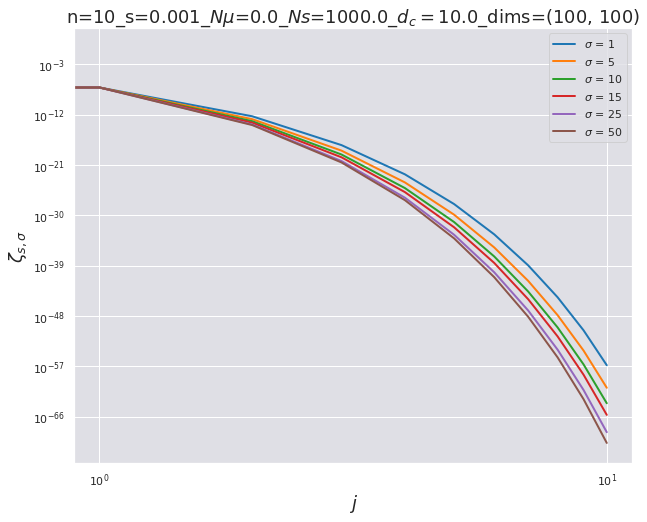

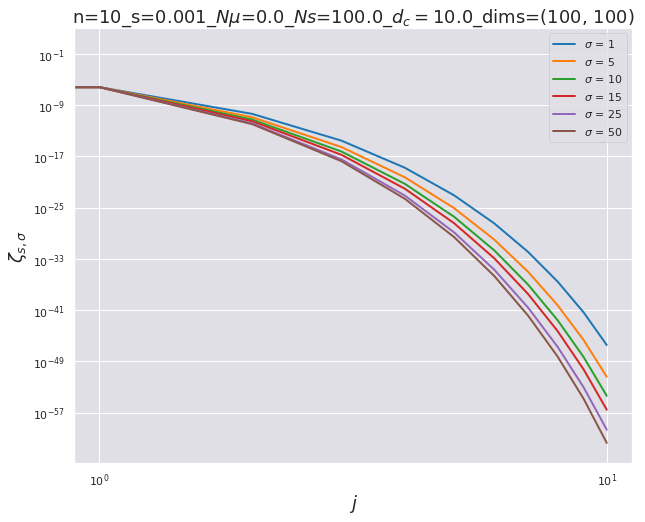

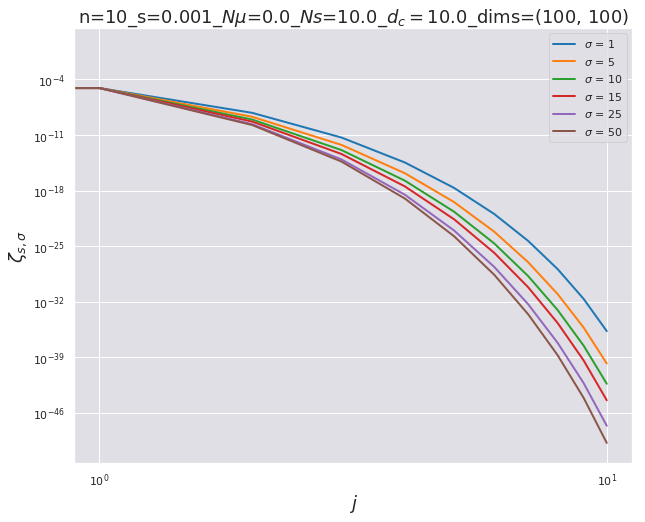

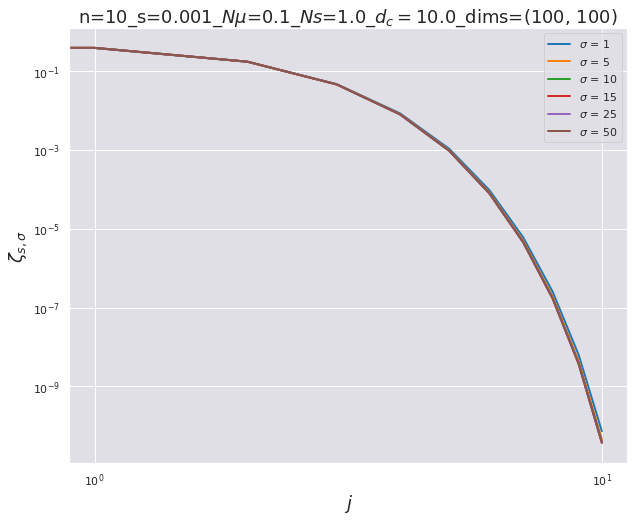

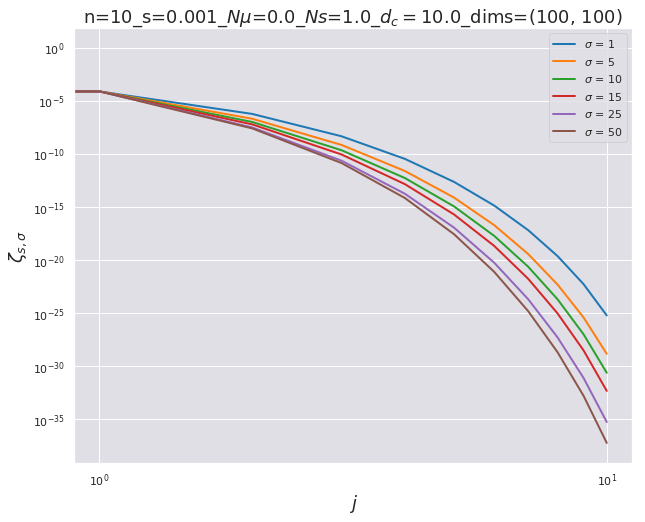

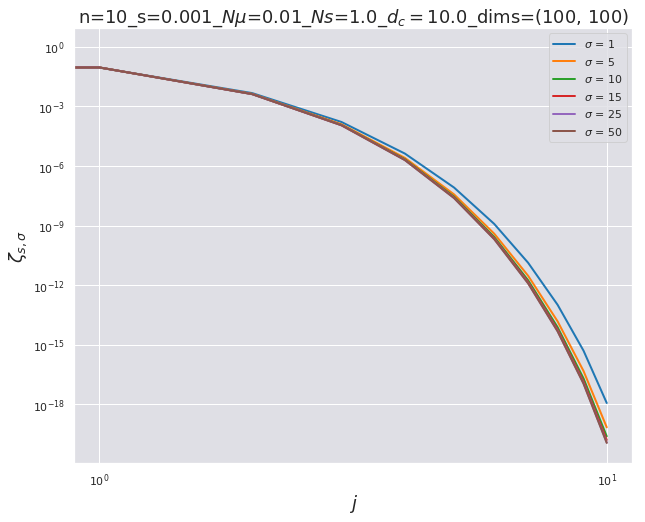

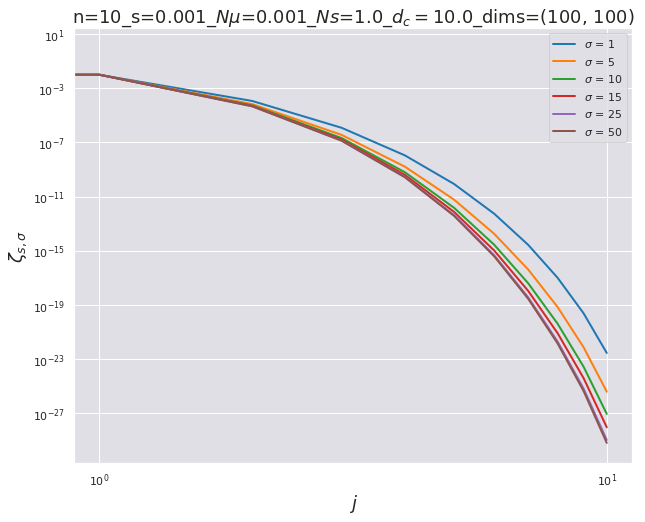

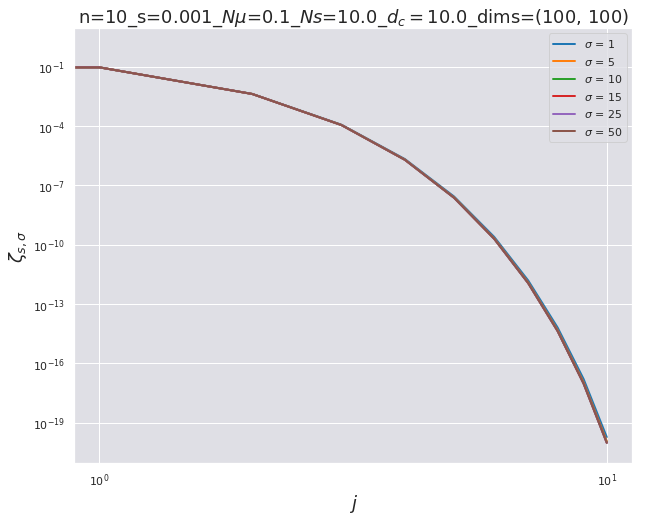

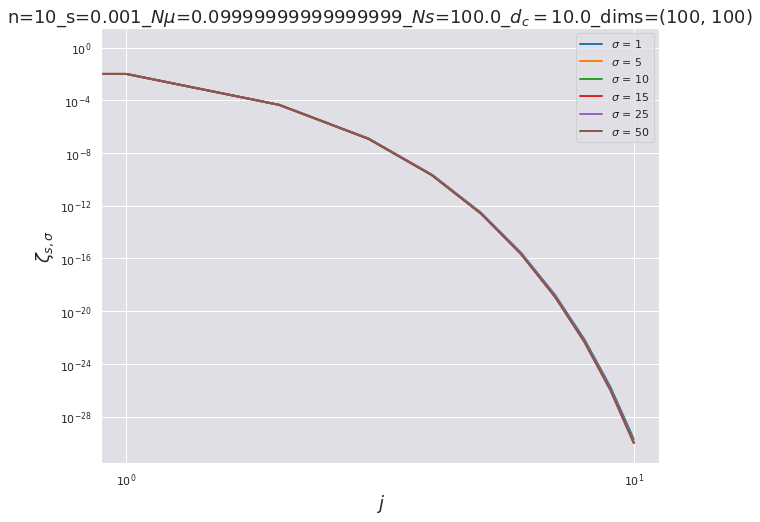

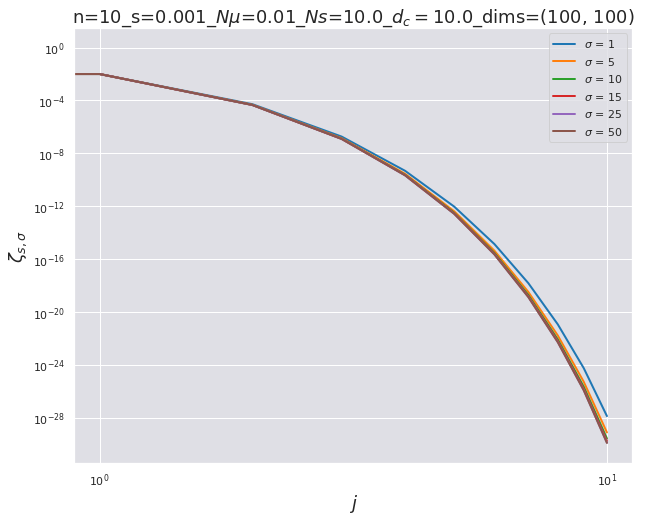

In [35]:
sig_list = [1, 5, 10, 15, 25, 50]
n = 10

plot_sfs(test_sims,sig_list,n)